# Deep Learning &mdash; Assignment 10

Assignment for week 10 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_November 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a diffusion model
2. Extend the model to a conditional model

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l==1.0.0a1.post0
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 537 kB/s 
     |████████████████████████████████| 121 kB 57.3 MB/s 
     |████████████████████████████████| 1.6 MB 64.9 MB/s 
     |████████████████████████████████| 83 kB 995 kB/s 


## 10.1 MNIST dataset

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes.

As preprocessing, we pad the images to 32x32 pixels and scale the intensities to [-1, +1].

**(a) Run the code below to load the MNIST dataset.**

In [ ]:
opts = {'batch_size': 128, 'shuffle': True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),    # pad to 32x32 pixels
        transforms.Normalize(0.5, 0.5),
    ])),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),    # pad to 32x32 pixels
        transforms.Normalize(0.5, 0.5),
    ])),
    **opts)
num_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 10.2 Training images (4 points)

We will implement a model from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

We reuse some parameter settings from the paper:

In [ ]:
diffusion_steps = 1000
beta = torch.linspace(1e-4, 0.02, diffusion_steps)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

Using these settings, we can generate a sequence of noisy images with
\begin{aligned}
\mathbf{x}_t 
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{aligned}

There is a closed-form solution to compute $x_t$ directly from $x_0$ (see the paper or [this blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#forward-diffusion-process)):
\begin{aligned}
\mathbf{x}_t &= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} & \text{ where } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{aligned}

**(a) Implement this closed-form solution in the code below to generate random images.<span style="float:right"> (1 point)</span>**

*Expected output: you should see some images with recognizable shapes and some images with noise.*

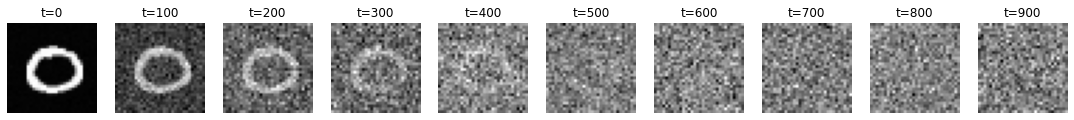

In [ ]:
# sample some original images
x_0, y = next(iter(train_iter))

plt.figure(figsize=(19, 21))
for i, t in enumerate(range(0, diffusion_steps, 100)):
    # TODO generate random noise
    noise = torch.randn_like(x_0)

    # TODO add noise to the original image to compute x_t
    x_t = np.sqrt(alpha_bar[t]) * x_0 + np.sqrt(1 - alpha_bar[t]) * noise

    plt.subplot(3, diffusion_steps // 100, i + 1)
    plt.imshow(x_t[0, 0], cmap='gray')
    plt.axis('off')
    plt.title(f't={t}')
    

**(b) Describe how we should interpret these images, and how they can be used to train the diffusion model.<span style="float:right"> (2 points)</span>**

We observe that as the noise applied to the image increases, it is harder to tell whihc number it is represented, until y becomes completely impossible. However, the noisy images is just a latent representation of the original image, which we should be able to reconstruct with a proper trained model.

During training, we will need a minibatch with multiple images and multple time steps.

**(c) Complete the function below to add noise to a minibatch of images.<span style="float:right"> (1 point)</span>**

In [ ]:
def generate_noisy_samples(x_0, beta):
    '''
    Create noisy samples for the minibatch x_0.
    Return the noisy image, the noise, and the time for each sample.
    '''
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    # sample a random time t for each sample in the minibatch
    t = torch.randint(beta.shape[0], size=(x_0.shape[0],), device=x_0.device)
    # TODO generate noise
    noise = torch.randn_like(x_0)
    # TODO add the noise to each sample
    x_t = torch.tensor([], device=x_0.device)
    for i, image in enumerate(x_0):
      x_t = torch.cat((x_t, torch.sqrt(alpha_bar[t[i]]) * image + torch.sqrt(1 - alpha_bar[t[i]]) * noise[i]))
    x_t = x_t.reshape(-1, 1, 32, 32)
    return x_t, noise, t

**(d) Try out your new function by generating a few noisy samples.**

*Expected output: you should see the samples in the minibatch with different levels of noise, depending on the time $t$ for each sample.*

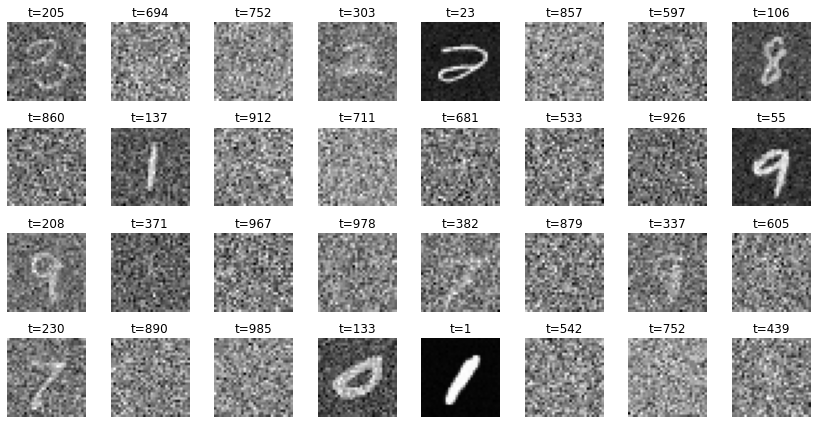

In [ ]:
x_0, y = next(iter(train_iter))

x_t, noise, sampled_t = generate_noisy_samples(x_0, beta)
assert x_t.shape == x_0.shape
assert noise.shape == x_0.shape
assert sampled_t.shape == (x_0.shape[0],)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x_t[i, 0], cmap='gray')
    plt.axis('off')
    plt.title(f't={sampled_t[i]}')
    plt.tight_layout()

## 10.3 Helper functions

We will use some predefined components to construct our model, based on [an existing implementation](https://github.com/dome272/Diffusion-Models-pytorch) on GitHub.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value

class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x

# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## 10.4 Diffusion model (4 points)

Similar to Ho et al. and to several online implementations, we will use a U-Net with self-attention and positional embedding as our diffusion model.

**(a) Familiarize yourself with the architecture of this U-Net.**

In [ ]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, device="cuda"):
        super().__init__()
        self.device = device
        
        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

**(b) What does the positional encoding encode? Why would this be useful?<span style="float:right"> (2 points)</span>**

The positions of each t value are being encoded in the input of the network. Just like what happened with any regular self-attention network, this will be useful to keep information about the order of the sequence of t values in the input, insted of just feeding a bunch of x values with no notion of order.

**(c) Describe how this model will be used. What do the inputs and outputs represent?<span style="float:right"> (2 points)</span>**

*Used for:* The model should be capable of obtaining a noise-free version of an image from the dataset based on an initial noisy version.

*Inputs:* Noisy batches of images.

*Outputs:* Original images.

## 10.5 Training the model (7 points)

We will train our diffusion model using Algorithm 1 from the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) by Ho et al., 2020.

**(a) The algorithm uses $\mathbf{x}_0$. How do you obtain $\mathbf{x}_0$ during training?<span style="float:right"> (1 point)</span>**

We define q(x_0) as an approximation of x_0, so, we use the noisy image as an approximation and train the network to learn the noise that should be added.

**(b) Which two values are compared in the loss on line 5 of the algorithm?<span style="float:right"> (1 point)</span>**

The comparison is between the total error an the error at time "t", its square difference is used as  loss function since we are just attempting to predict the error through our model.

**(c) Implement this procedure in the training loop below.<span style="float:right"> (3 points)</span>**

In [ ]:
def train(model, beta, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            optimizer.zero_grad()
            # hint: we already have a function to generate noisy images
            x_t , noise, t = generate_noisy_samples(x, beta)
            output = model(x_t, t)
            loss = torch.nn.MSELoss()(output, noise)
            
            # Optimize
            loss.backward()
            optimizer.step()
            
            # Track our progress
            metric.add(loss.detach(), x.shape[0])
        train_loss = metric[0] / metric[1]
            
        # Compute test loss
        metric = d2l.Accumulator(2)
        model.eval()
        for x, y in test_iter:
            x = x.to(device)
            with torch.no_grad():
                _, noise, t = generate_noisy_samples(x, beta)
                output = model(x, t)
                loss = torch.nn.MSELoss()(output, noise)
                metric.add(loss.detach(), x.shape[0])
        test_loss = metric[0] / metric[1]
        
        # Plot
        animator.add(epoch + 1, (train_loss, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')

**(d) How does the training time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

The training time does not depend much on the number of steps because on each iteration, the loss function is calculated with a simplified version of the formula that does not require recursive evaluation step by step. Therefore, the training can be done much faster, and a higher t value might make computation of larger matrixes a bit more demanding, but not significantly different.

**(e) Train the model.**

*Expected output: in our implementation, the loss started around 0.0010 and went down quickly to 0.0002 and lower.*

training loss 0.000, test loss 0.013


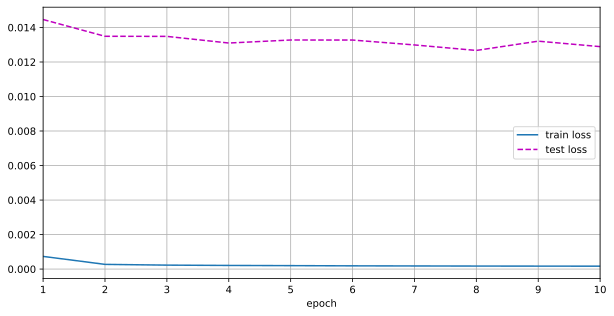

In [ ]:
device = d2l.try_gpu()

model = UNet().to(device)
train(model, beta, num_epochs=10, lr=1e-4)

**(f) Has the training converged? Do you think we should train longer?<span style="float:right"> (1 point)</span>**

The training seems to have converged to a preety decent loss, meaning that there is no reason to keep training further.

## 10.6 Sampling from the model (8 points)

Once the model is trained, we can sample from it using Algorithm 2 from paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf):

**Algorithm 2**:  
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf 0, \mathbf I)$  
2: for $t = T, \dots, 1$ do  
3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \sim \mathcal{N}(\mathbf 0, \mathbf I)$ if $t > 1$, else $\mathbf{z} = \mathbf{0}$  
4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{x}_{t-1} = \frac{1}{\sqrt{a_t}} \left( \mathbf{x}_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}} \mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)\right) + \mathbf{\sigma}_t \mathbf{z}$  
5: end for  
6: return $\mathbf{x}_0$

**(a) In step 3 of algorithm 2, $\mathbf{z}$ is set to $\mathbf{0}$ some times. What is the effect of this?<span style="float:right"> (1 point)</span>**

The effect of this is that the last part of the formula to calculated the Xt-1 is zero so the formula will be like this.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{x}_{t-1} = \frac{1}{\sqrt{a_t}} \left( \mathbf{x}_t - \frac{1-a_t}{\sqrt{1-\bar{a}_t}} \mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)\right)$



**(b) In step 4 of algorithm 2, $\mathbf{x}_{t-1}$ is computed based on three ingredients: $\mathbf{x}_t$, $\mathbf{\epsilon}_\theta \left(\mathbf{x}_t, t\right)$, and $\mathbf{z}$. What do these represent? <span style="float:right"> (2 points)</span>**


As shown above, we can derive a slighly less denoised image Xt−1 by plugging in the reparametrization of the mean, using our noise predictor.

 Since $\mathbf{x}_t$ is available as input to the model, we may choose the parameterization in which $\mathbf{\epsilon}_\theta$ is a function approximator intended to predict $\mathbf{\epsilon}$ from $\mathbf{x}_t$. Moreover, we have that z is N (0,I). This complete sampling procedure resembles Langevin dynamics with $\mathbf{\epsilon}_\theta$ as a learned gradient of the data density.

**(c) How does the sampling time depend on the number of diffusion steps $T$?<span style="float:right"> (1 point)</span>**

We start from T and we end up at time step t = 0, so the sampling time depens on T in a directed way. If T is big the model will have more sampling time,this would be assuming that the value of beta is constant. 

**(d) Complete the code below to sample a minibatch from the model.<span style="float:right"> (2 points)</span>**

* Use the equations in Algorithm 2.
* Use $\sigma_t = \sqrt{\beta_t}$, as suggested in the paper.
* Keep in mind that Algorithm 2 uses $t=1$ as the first time step, whereas we use $t=0$.

*Expected output: after training, your model should generate fairly realistic, clean images when given random inputs.*

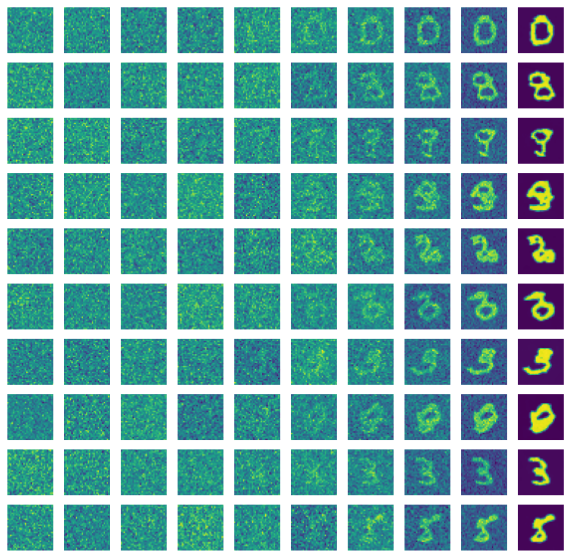

In [ ]:
def sample_from_model(x, model, beta):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            
            # TODO compute the next value of x
            pred_noise=model(x,t)
            alpha1 = alpha[t].to(device)
            alpha1 = alpha1.view(-1,1,1,1)
            alpha_bar1 = alpha_bar[t].to(device)
            alpha_bar1 = alpha_bar1.view(-1,1,1,1)
            beta1 = beta[t].to(device)
            beta1 = beta1.view(-1,1,1,1)
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1/torch.sqrt(alpha1)*(x-((1-alpha1)/torch.sqrt(1-alpha_bar1))*pred_noise)+torch.sqrt(beta1)*noise  
            if i % 100 == 0:

                x_hist.append(x.detach().cpu().numpy())

    return x, x_hist

def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, 10, j * 10 + i + 1)
            plt.imshow(x_hist[i][j, 0])
            plt.axis('off')


# TODO initialize x with the right values
# shape: [10, 1, 32, 32]

x = torch.zeros_like(x_0[:10]).to(device)

x, x_hist = sample_from_model(x, model, beta)

plot_x_hist(x_hist)

**(e) Explain the X and Y axes of this figure.<span style="float:right"> (1 point)</span>**

In the Y axis we can see the the different classes, in this case the numbers. Instead, in the X axis we can see how as we move along the x-axis the images have less and less noise.


**(f) In a variational autoencoder or a GAN, the output is determined by the latent representation. How does that work for this diffusion model?<span style="float:right"> (1 point)</span>**

Diffusion models are inspired by non-equilibrium thermodynamics. They define a Markov chain of diffusion steps to slowly add random noise to data and then learn to reverse the diffusion process to construct desired data samples from the noise. Unlike VAE or flow models, diffusion models are learned with a fixed procedure and the latent variable has high dimensionality (same as the original data).


## 10.7 Experiments (5 points)

### Fixed initialization

How does the end result depend on the initialization? We will generate multiple images from the same initial noise to find out.

**(a) Complete and run the code below.</span>**

*Expected output: the model should still produce recognizable shapes.*

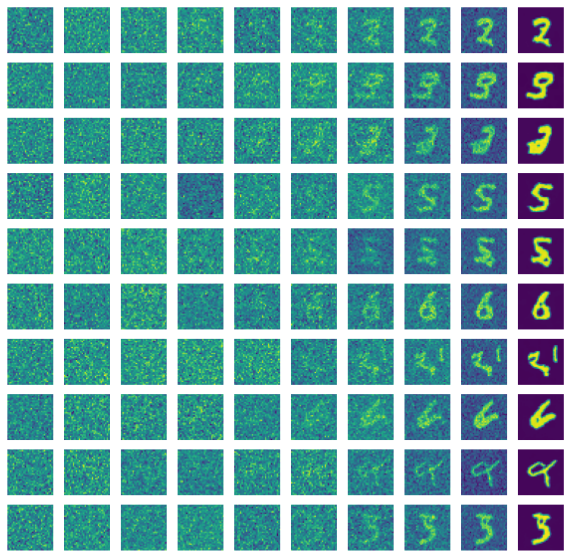

In [ ]:
def sample_from_model(x, model, beta):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            
            # TODO compute the next value of x
            pred_noise=model(x,t)
            alpha1 = alpha[t].to(device)
            alpha1 = alpha1.view(-1,1,1,1)
            alpha_bar1 = alpha_bar[t].to(device)
            alpha_bar1 = alpha_bar1.view(-1,1,1,1)
            beta1 = beta[t].to(device)
            beta1 = beta1.view(-1,1,1,1)
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1/torch.sqrt(alpha1)*(x-((1-alpha1)/torch.sqrt(1-alpha_bar1))*pred_noise)+torch.sqrt(beta1)*noise  
            if i % 100 == 0:

                x_hist.append(x.detach().cpu().numpy())

    return x, x_hist

def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, 10, j * 10 + i + 1)
            plt.imshow(x_hist[i][j, 0])
            plt.axis('off')


x_t ,_,_ = generate_noisy_samples(x, beta)
x = x_t[:1].to(device) 

x = x.repeat(10, 1, 1, 1)
x, x_hist = sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(b) Does the model always produce the same output from the same initial input? Why, or why not?<span style="float:right"> (2 points)</span>**

No, the model is not producing the same input. That's because all the outputs are calculated with some random noise part.

### No randomness between time steps

To check the influence of noise during sampling, we can remove the term $\sigma_t \mathbf{z}$ from Algorithm 2.

**(c) Create a new function `deterministic_sample_from_model`, based on `sample_from_model`, that does not include this term.<span style="float:right"> (2 points)</span>**

In [ ]:
def deterministic_sample_from_model(x, model, beta):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            
            # TODO compute the next value of x
            pred_noise=model(x,t)
            alpha1 = alpha[t].to(device)
            alpha1 = alpha1.view(-1,1,1,1)
            alpha_bar1 = alpha_bar[t].to(device)
            alpha_bar1 = alpha_bar1.view(-1,1,1,1)
            beta1 = beta[t].to(device)
            beta1 = beta1.view(-1,1,1,1)
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1/torch.sqrt(alpha1)*(x-((1-alpha1)/torch.sqrt(1-alpha_bar1))*pred_noise)  
            if i % 100 == 0:
              x_hist.append(x.detach().cpu().numpy())

    return x, x_hist

def plot_x_hist(x_hist):
    # plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(len(x_hist)):
        for j in range(10):
            plt.subplot(10, 10, j * 10 + i + 1)
            plt.imshow(x_hist[i][j, 0])
            plt.axis('off')




**(d) Generate some samples using the new function.**

*Expected output: you should get a different result than before.*

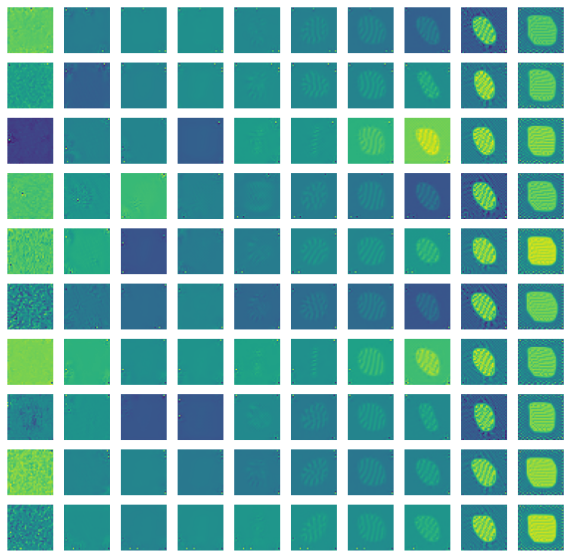

In [ ]:

# shape: [10, 1, 32, 32]
x = torch.randn_like(x_0[:10]).to(device)

x, x_hist = deterministic_sample_from_model(x, model, beta)
plot_x_hist(x_hist)

**(e) What can you conclude from these results? Is the random noise during sampling important?<span style="float:right"> (1 point)</span>**

As we saw, it is really important, the plot with the noise parameter was so much better than this one. In this one we are not able to see any digit.

## 10.8 Making the model conditional (6 points)

Similar to the conditional VAE in the previous assignment, we can make the diffusion model conditional by including class labels. This allows us to generate samples from a specific digit.

We will include the class information alongside the existing positional encoding, using a [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer to map the 10 digits to a higher-dimensional space.

### Conditional model

**(a) Study the implemenation of UNetConditional to see how this works.**

In [ ]:
class UNetConditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, n_classes=10, device="cuda"):
        super().__init__()
        self.device = device
        
        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4) 
        self.sa3 = SAWrapper(128, 8)
        
        self.label_embedding = nn.Embedding(n_classes, 256)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def label_encoding(self, label, channels, embed_size):
        return self.label_embedding(label)[:, :channels, None, None].repeat(1, 1, embed_size, embed_size)
    
    def forward(self, x, t, label):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.label_encoding(label, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.label_encoding(label, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.label_encoding(label, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.label_encoding(label, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.label_encoding(label, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.label_encoding(label, 64, 32)
        output = self.outc(x)
        return output

**(b) As in [the paper by Ho et al.](https://arxiv.org/pdf/2006.11239.pdf), the position and label encoding are added in every layer of the model, instead of as an input to the first layer only. Why do you think the authors made this choice?<span style="float:right"> (1 point)</span>**

Positional encoding and the label are added at every layer on $t$ in order to keep track at each step of the noising process, as well as try to improve sample quality and train the model as a latent variable model.

### Conditional training loop

**(c) Create a new function `train_conditional` to train this model.<span style="float:right"> (1 point)</span>**

In [ ]:
def train_conditional(model, beta, num_epochs=10, lr=1e-3):
    # TODO implement the training loop, based on your earlier train function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for x, y in train_iter:
            y = y.to(device)
            x = x.to(device)
            optimizer.zero_grad()
            
            # hint: we already have a function to generate noisy images
            x_t , noise, t = generate_noisy_samples(x, beta)
            output = model(x_t, t, y)
            loss = torch.nn.MSELoss()(noise,output)
            
            # Optimize
            loss.backward()
            optimizer.step()
            
            # Track our progress
            metric.add(loss.detach(), x.shape[0])
        train_loss = metric[0] / metric[1]
            
        # Compute test loss
        metric = d2l.Accumulator(2)
        model.eval()
        for x, y in test_iter:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                # TODO compute the loss for minibatch x
                x_t, noise, t = generate_noisy_samples(x, beta)
                output = model(x_t, t, y)
                loss = torch.nn.MSELoss()(noise,output)
                metric.add(loss.detach(), x.shape[0])
        test_loss = metric[0] / metric[1]
        
        # Plot
        animator.add(epoch + 1, (train_loss, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')

**(d) Train the conditional model.**

*Expected output: in our implementation, the loss started around 0.0010 and went down quickly to 0.0002 and lower.*

training loss 0.000, test loss 0.000


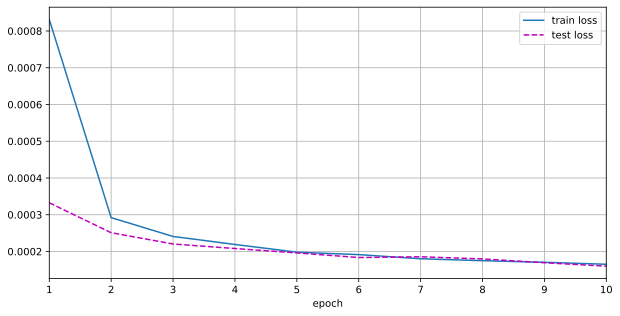

In [ ]:
model_conditional = UNetConditional().to(device)
train_conditional(model_conditional, beta, num_epochs=10, lr=1e-4)

### Conditional sampling

**(e) Modify the sampling function to include a label.<span style="float:right"> (1 point)</span>**

In [ ]:
def sample_from_model_conditional(x, model, beta, label):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            
            # TODO compute the next value of x
            pred_noise=model(x,t,label)
            alpha1 = alpha[t].to(device)
            alpha1 = alpha1.view(-1,1,1,1)
            alpha_bar1 = alpha_bar[t].to(device)
            alpha_bar1 = alpha_bar1.view(-1,1,1,1)
            beta1 = beta[t].to(device)
            beta1 = beta1.view(-1,1,1,1)
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1/torch.sqrt(alpha1)*(x-((1-alpha1)/torch.sqrt(1-alpha_bar1))*pred_noise)+torch.sqrt(beta1)*noise  
            if i % 100 == 0:

                x_hist.append(x.detach().cpu().numpy())

    return x, x_hist

**(f) Sample a few digits with label `3`.<span style="float:right"> (1 point)</span>**

*Expected output: you should see recognizable images with the number you requested.*

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')


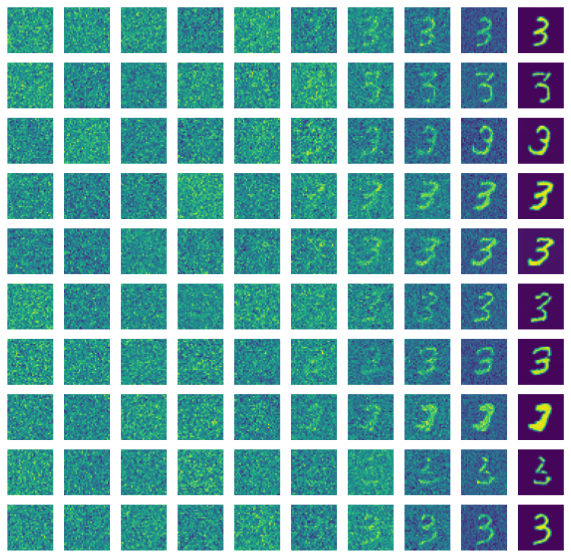

In [ ]:
x = torch.zeros_like(x_0[:10]).to(device)

label = torch.Tensor([3] * 10).long().to(device)
print(label)
x, x_hist =  sample_from_model_conditional(x, model_conditional, beta, label)
plot_x_hist(x_hist)

**(g) Complete the code to sample and plot 10 samples for every digit.<span style="float:right"> (1 point)</span>**

In [ ]:
x_per_class = []
for label in range(10):
    # sample 10 digits with this label
    x = torch.zeros_like(x_0[:10]).to(device)   
    label = torch.Tensor([label] * 10).long().to(device) 
    x, x_hist =  sample_from_model_conditional(x, model_conditional, beta,label)
    x_per_class.append(x.detach().cpu().numpy())

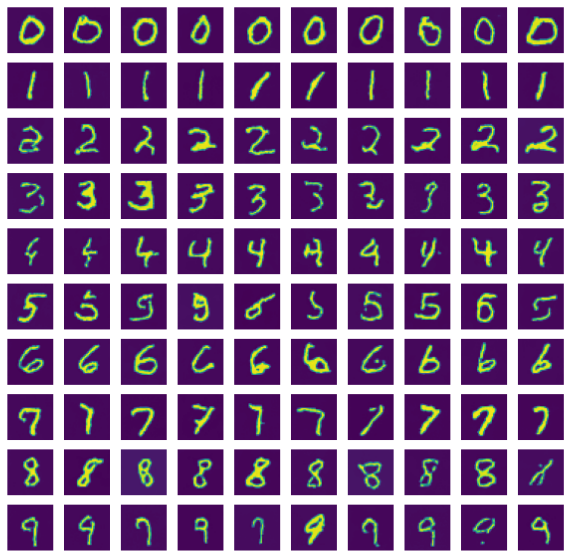

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(x_per_class[j][i, 0])
        plt.axis('off')

**(h) Compare the output of the conditional model with that of the unconditional model. Which one is better?<span style="float:right"> (1 point)</span>**

Instead of a random dataset example, the model converges to a specific handwritten digit that belongs to the specific label we are conditioning on. This model is clearly better because it allows us to clearly guide our sampling towards a specific label data point instead of just retrieving a random one.

## 10.9 Discussion (6 points)

**(a) Compare the source randomness in our diffusion model with that in the variational autoencoder and the GAN in earlier assignments. What are the main differences?<span style="float:right"> (1 point)</span>**

The randomness in difussion models is applied directly to the input instead of generating it from a trained model that receives output from a discriminator like in a GAN. Also, the randomness is applied in a way that the output remains in the same size as the input, whereas VAEs create smaller dimensional representations of images with their randomness.
The randomness is always applied with the same function (just with different alpha beta values in each step), while GANs and VAEs have more complex ways for introducing rnadomness in the input.

**(b) Would you be able to train a good digit classification model on the initial input to the sampling function? Why, or why not?<span style="float:right"> (1 point)</span>**

Hint: for variational autoencoders and GANs, there is a clear link between the input (a latent feature vector) and the output of the decoder. How does this work for our diffusion model?

The noise added to the image depends on the time step t after which noise was accumulated. If we just input image with no notion of which t are we stepped into, we have no clear link between input and output, hence we cannot rely solely on this data.

**(c) When loading the data, we normalized the image intensities to [-1, +1], instead of [0, 1] or [0, 255]. Why is this a good input range for this diffusion model?<span style="float:right"> (1 point)</span>**

We assume that image data consists of integers in {0, 1, . . . , 255} scaled linearly to [−1, 1]. This ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior p(xT)

**(d) In this assignment, we use a $\beta$ schedule that has a small $\beta=1e-4$ at the initial time steps ($t=0$), and a larger $\beta=0.02$ at the end ($t=T$). Why is it useful to choose an inreasing $\beta$?<span style="float:right"> (1 point)</span>**

These constants were chosen to be small
relative to data scaled to [−1, 1], ensuring that reverse and forward processes have approximately the same functional form while keeping the signal-to-noise ratio at xT as small as possible.


**(e) What would happen if we made $\beta$ very small?<span style="float:right"> (1 point)</span>**

The step sizes are controlled by a variance schedule, this variance schedule is β so if we made it very small we will probably need more sampling time to achieve a result.

**(f) What would happen if we made $\beta$ very large?<span style="float:right"> (1 point)</span>**

As explained above, the β parameter controls the step sizes, which are determined by T. If the steps are too large, we will probably get a faster result, but this result should be worse than one with a smaller β.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 40 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 67eae2d / 2022-11-23</span>